In [39]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import sklearn.model_selection
import sklearn.metrics
import models
import util
import os
import config
import viz
import scipy.stats
from tqdm import tqdm
import figs
import matplotlib.image as mpimg
import seaborn as sns
import data
CELEB_IMS_DIR = '../data/celeba-hq/ims/'
CELEB_ANNO_DIR = '../data/celeba-hq/Anno/'

# load and merge all the data
print('loading...')
df = data.load_ids()
labs, labs_full = data.load_labs()
for k in labs.keys():
    df[k] = labs[k].values
print('done loading!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loading...
done loading!


## show some frequent celebs

In [3]:
labs_full.keys()

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

In [ ]:
d = df[df['count_with_this_id'] > 20]
d = d[d['skin-color'] == 0] # filter by skin color
# d = d[d['gender'] == 1] # filter by skin color

for i in d['id'].unique()[:20]:
    ids = d[d.id == i]
    print(ids.shape)
    ims = np.array([mpimg.imread(oj(CELEB_IMS_DIR, fname))
                    for fname in ids.fname_final.values])
    print(ims.shape)
    util.plot_row(ims)
    plt.show()

# look at image statistics

In [ ]:
df['gender']

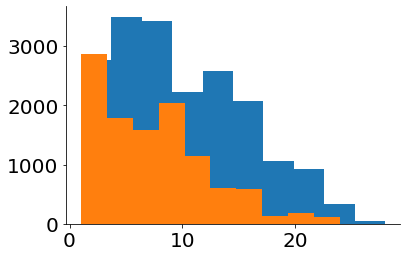

In [13]:
plt.hist(df[df['gender'] == 0]['count_with_this_id'], label='Female')
plt.hist(df[df['gender'] == 1]['count_with_this_id'], label='Male')
plt.show()
# plt.hist(df[df['gender'] == 1])

# look at id stats

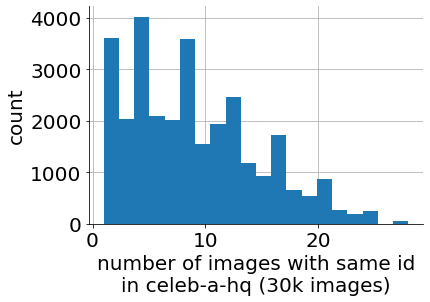

In [116]:
plt.grid(zorder=-1)
plt.hist(df['count_with_this_id'], bins=20, zorder=3)
plt.xlabel('number of images with same id\nin celeb-a-hq (30k images)')
plt.ylabel('count')
plt.show()

In [117]:
ids.head()

,idx,orig_idx,orig_file,proc_md5,final_md5,id,fname_final,count_with_this_id,gender,hair-length,facial-hair,makeup,skin-color,age
0,0,119613,119614.jpg,0be7e162e25c06f50dd5c1090007f2cf,d76ed3e87c8bc20f82757a2dd95026ba,7423,00001.jpg,6,0,1,1,1,0,0
1,1,99094,099095.jpg,1e2d301e9b3d1b64b2e560243b5c109c,c391ae358c1a00e715982050b6446109,7319,00002.jpg,3,0,1,1,1,0,0
2,2,200121,200122.jpg,99aa914661dc10dfbaf14579757f6ab8,a131f037e52aa1011a90cf78f7b0cd88,6632,00003.jpg,12,0,1,1,0,0,0
3,3,81059,081060.jpg,ff2a42ed253c393c3cebe37c456c47fb,9908aba4e7dbee68224726dd97ee21fa,3338,00004.jpg,6,0,1,1,1,0,0
4,4,202040,202041.jpg,8a249cfe4671d3f53eba90c6f1762005,464440733a22e53073575cd4081f5501,9178,00005.jpg,14,0,1,1,0,0,0


# let's do some GAN space matching

In [156]:
DIR_ORIG = '../data/celeba-hq/ims/'
IM_NUMS = np.arange(1, 901)

DIRS_GEN = '../data_processed/celeba-hq/'
reg = 0.1
DIR_GEN = oj(DIRS_GEN, f'generated_images_{reg}')

In [157]:
latents_fnames = [f for f in sorted(os.listdir(DIR_GEN)) if 'npy' in f]
latents = np.array([np.load(oj(DIR_GEN, f)) for f in latents_fnames[:IM_NUMS.size]])

**can match in style space or extended style space**

In [158]:
lat = latents.mean(axis=1) # match in style space
# lat = latents.reshape(latents.shape[0], -1) # match in extended style space

In [159]:
lat.shape

(900, 512)

**can match on different metrics**

In [167]:
# calculate distances: (points, points)
dists = sklearn.metrics.pairwise_distances(lat, metric='cosine') # cosine dist
# dists = sklearn.metrics.pairwise_distances(lat, metric='l2') # cosine dist
# sns.clustermap(dists)
dists[np.eye(dists.shape[0]).astype(bool)] = 1e3 # don't pick same point
# plt.imshow(dists)
# dists_min = np.argmin(dists, axis=1)

## show matches for an im

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


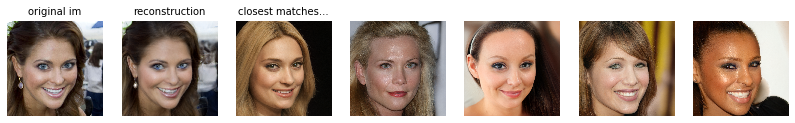

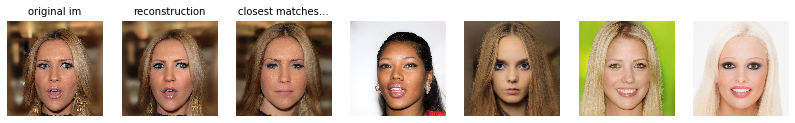

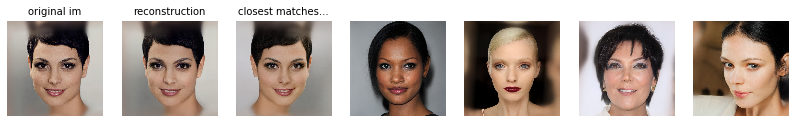

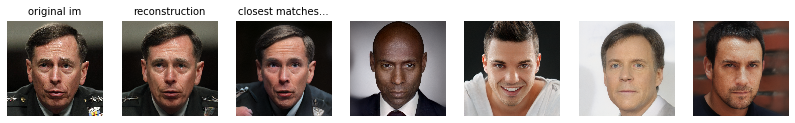

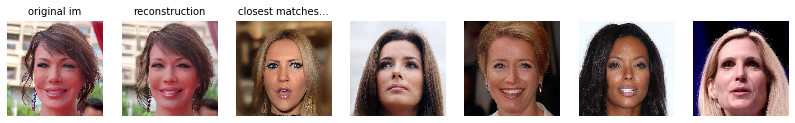

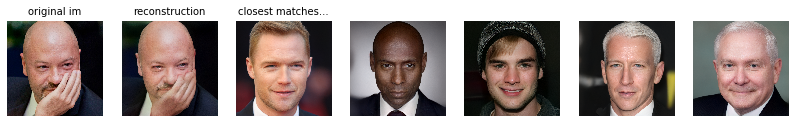

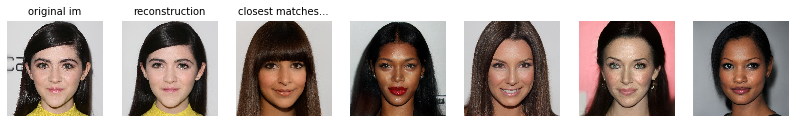

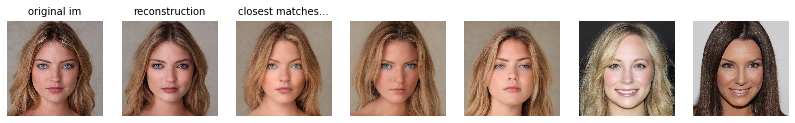

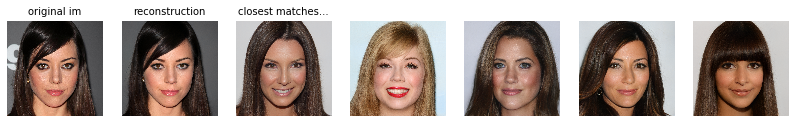

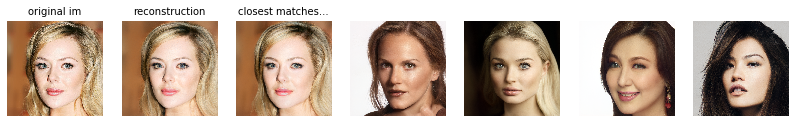

In [171]:
# pick the image
im_nums = range(60, 70)
for im_num in im_nums:
    R, C = 1, 7
    plt.figure(figsize=(C * 2, R * 2))

    plt.subplot(R, C, 1)
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{im_num:05}.jpg'))
    util.imshow(im_orig)
    plt.title('original im', fontsize=10)

    plt.subplot(R, C, 2)
    im_rec = mpimg.imread(oj(DIR_GEN, f'{im_num:05}.png'))
    util.imshow(im_rec)
    plt.title('reconstruction', fontsize=10)

    closest_matches = np.argsort(dists[im_num - 1])
#     print(dists[im_num - 1][closest_matches])
    plt.subplot(R, C, 3)
    plt.title('closest matches...', fontsize=10)
    for i in range(C - 2):
        plt.subplot(R, C, i + 3)
        matched_num = closest_matches[i] + 1
        im = mpimg.imread(oj(DIR_GEN, f'{matched_num:05}.png'))
        util.imshow(im)

In [ ]:
# for im_num in IM_NUMS[:3]:
#     im_orig = mpimg.imread(oj(DIR_ORIG, f'{im_num:05}.jpg'))
#     im_rec = mpimg.imread(oj(DIR_GEN, f'{im_num:05}.png'))
#     util.imshow(im_orig)
#     plt.show()
#     util.imshow(im_rec)
#     plt.show()